<a href="https://colab.research.google.com/github/westengine/Fashion-MNIST-Classification-Recommendation/blob/main/Fashion_MNIST_Classification_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Installation and Importing Libraries**
This section installs necessary Python libraries (`gradio`, `lightfm`) and imports essential modules for data manipulation, visualization, and machine learning. Libraries like `tensorflow`, `pandas`, `numpy`, and `matplotlib` are used for data processing and visualization. `scikit-learn` provides tools for data preprocessing and model evaluation.

In [ ]:
!pip install gradio lightfm

import os
import kagglehub
import tensorflow as tf
import pandas as pd
import numpy as np
import gradio as gr
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from keras import layers, models

from lightfm import LightFM
from lightfm.data import Dataset
from keras.models import Sequential
from keras.layers import LSTM, Dense

from scipy.sparse import csr_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.4 MB/s eta 0:00:00
  Created wheel for lightfm: filename=lightfm-1.17-cp311-cp311-linux_x86_64.whl size=831164 sha256=1371257d9ac0978be51a66a62f347e5d51b5a76f5b7e37eb233a53aaf3edc3c2
  Stored in directory: /root/.cache/pip/wheels/b9/0d/8a/0729d2e6e3ca2a898ba55201f905da7db3f838a33df5b3fcdd
Successfully built lightfm
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling Marku

# **Downloading Dataset**
This cell downloads the Fashion MNIST dataset from Kaggle using `kagglehub.dataset_download`. The dataset contains images of clothing items categorized into different classes. The path where the dataset is stored is printed for reference.

In [ ]:
# save filepath to variable for easier access
path = kagglehub.dataset_download("zalando-research/fashionmnist")

print("Path to dataset files:", path)

100%|██████████| 68.8M/68.8M [00:00<00:00, 168MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/zalando-research/fashionmnist/versions/4


# **Loading Dataset**
The dataset is read using `pd.read_csv()` and stored in a Pandas DataFrame named `train_df`. This allows for easy manipulation and preprocessing of the data.

In [ ]:
# read the data and store data in dataframe titled train_df
train_df = pd.read_csv(os.path.join(path, "fashion-mnist_train.csv"))

# **Viewing First Few Rows**
The `head()` method is used to display the first few rows of the dataset. This helps to inspect the structure of the dataset, including its features and labels.

In [ ]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **Data Preparation**
The dataset is split into features (`x`) and labels (`y`). Features (`x`) contain pixel values of images, while labels (`y`) represent the corresponding clothing categories.

In [ ]:
# prepare the data
x = train_df.iloc[:, 1:]
y = train_df.iloc[:, 0]

# **Reshaping and Normalizing the Data**
The dataset is reshaped to match the input format required by a convolutional neural network (CNN).
- `x.values.reshape(x.shape[0], 28, 28, 1)`: Converts the dataset into a 4D array with a single channel (grayscale images).
- `X = X / 255`: Normalizes pixel values to be between 0 and 1 for better model convergence.

In [ ]:
# reshape and normalize the data
X = x.values.reshape(x.shape[0], 28, 28, 1)
X = X / 255

# **Splitting the Data**
The dataset is split into training and testing sets using an 80-20 split.
- `train_test_split(X, y, test_size=0.2, random_state=42)`: Ensures that 20% of the dataset is reserved for testing while maintaining reproducibility with `random_state=42`.

In [ ]:
# split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Building the CNN Model**
A Convolutional Neural Network (CNN) is created using TensorFlow's `Sequential` API. The model consists of:
- **Two convolutional layers (`Conv2D`)**: Extracts features from the image using 3×3 filters.
- **Two max-pooling layers (`MaxPooling2D`)**: Reduces spatial dimensions while preserving important features.
- **Flattening layer (`Flatten()`)**: Converts 2D feature maps into a 1D vector.
- **Dense layers (`Dense(128, activation='relu')`, `Dense(10, activation='softmax')`)**: Performs classification into 10 categories using the softmax activation function.

In [ ]:
# build the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# **Compiling the Model**
The model is compiled using:
- `Adam optimizer`: Adjusts weights dynamically for faster convergence.
- `Sparse Categorical Crossentropy loss function`: Suitable for multi-class classification with integer labels.
- `Accuracy metric`: Evaluates the model’s performance.

In [ ]:
# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# **Training the Model**
The model is trained for 10 epochs using:
- Training data (`x_train`, `y_train`).
- Validation data (`x_test`, `y_test`).
- `history = model.fit(...)` stores training metrics.
- `model.save('./fashion_cnn.h5')` saves the trained model for future use.

In [ ]:
# train the model
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
model.save('./fashion_cnn.h5')  # Saves model to your current working directory

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 37ms/step - accuracy: 0.7630 - loss: 0.6572 - val_accuracy: 0.8697 - val_loss: 0.3573
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 53s 35ms/step - accuracy: 0.8821 - loss: 0.3299 - val_accuracy: 0.8917 - val_loss: 0.3046
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 93s 42ms/step - accuracy: 0.8978 - loss: 0.2808 - val_accuracy: 0.8932 - val_loss: 0.2889
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 43ms/step - accuracy: 0.9093 - loss: 0.2444 - val_accuracy: 0.9061 - val_loss: 0.2625
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 75s 38ms/step - accuracy: 0.9208 - loss: 0.2126 - val_accuracy: 0.9043 - val_loss: 0.2596
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 76s 34ms/step - accuracy: 0.9306 - loss: 0.1862 - val_accuracy: 0.8999 - val_loss: 0.2885
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 86s 37ms/step - accuracy: 0.9394 - loss: 0.1653 - val_accuracy: 0.9057 - val_loss: 0.2730
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 37ms/step - accuracy: 0.9476 -

# **Evaluating the Model**
The trained model is tested on the test dataset using `model.evaluate()`.
- The test accuracy is printed to assess the generalization capability of the model.

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.9140 - loss: 0.2661
Test accuracy: 0.9125000238418579


# **Displaying Sample Predictions**
A set of 5 sample images is displayed along with the model’s predicted labels.
- Each image is reshaped and passed to `model.predict()`.
- The predicted label is determined using `np.argmax()`.
- The images are displayed using `matplotlib` with their corresponding predictions.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


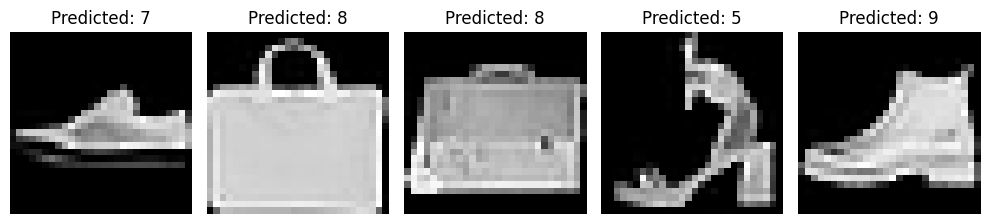

In [ ]:
# Display samples images with their predicted labels
num_images = 5
plt.figure(figsize=(10, 4))

for i in range(num_images):
    test_images = x_test[i].reshape(1, 28, 28, 1)
    predicted_label = np.argmax(model.predict(test_images))

    plt.subplot(1, num_images, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# **Loading Fashion MNIST Dataset from TensorFlow**
Instead of downloading from Kaggle, the dataset can be loaded directly using `tf.keras.datasets.fashion_mnist.load_data()`. This provides training and test sets for further analysis.

In [ ]:
# Load Fashion MNIST
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# **Generating Synthetic Sales Data**
A mock dataset is created to simulate weekly sales trends for 100 weeks.
- `date_range(start="2020-01-01", periods=100, freq="W")`: Generates weekly timestamps.
- `category`: Randomly assigned categories from Fashion MNIST.
- `sales_volume`: Random integer sales volume.
- `social_mentions`: Random social media mentions to simulate popularity.

In [ ]:
# Synthetic time-series sales data (mocked because we have no access to real time SM data)
dates = pd.date_range(start="2020-01-01", periods=100, freq="W")
sales_data = pd.DataFrame({
    'date': dates,
    'category': np.random.choice(10, 100),  # 10 Fashion MNIST categories
    'sales_volume': np.random.randint(100, 1000, 100),
    'social_mentions': np.random.randint(0, 500, 100)
})

# **Generating Synthetic User Interaction Data**
A dataset simulating user interactions with fashion items is created.
- `user_id`: 50 users, each interacting with 20 items.
- `item_id`: Randomly selected items.
- `clicked`: 30% probability of clicking on an item.
- `purchased`: 10% probability of purchasing an item.
This data can be used for building recommendation models.

In [ ]:
# Synthetic user interactions (user_id, item_id, rating)
user_interactions = pd.DataFrame({
    'user_id': np.repeat(np.arange(50), 20),
    'item_id': np.random.choice(len(train_images), 1000),
    'clicked': np.random.choice([0, 1], 1000, p=[0.7, 0.3]),
    'purchased': np.random.choice([0, 1], 1000, p=[0.9, 0.1])
})

# **Time-Series Trend Prediction using LSTM**
This section uses an LSTM (Long Short-Term Memory) network to predict future fashion trends based on historical sales and social media mentions.

### Steps:
1. **Preprocessing**:
   - The dataset is scaled using `MinMaxScaler()` to normalize sales and social data between 0 and 1.
2. **Sequence Creation**:
   - A function `create_sequences()` is defined to generate input-output pairs for time-series forecasting.
   - The data is split into overlapping sequences of 3 time steps each.
3. **Model Training**:
   - An LSTM-based neural network is built using `Sequential()`.
   - The network consists of 50 LSTM units followed by a Dense output layer with 2 neurons (predicting sales volume & social mentions).
   - The model is compiled with `adam` optimizer and trained for 20 epochs.

In [ ]:
# Trend Prediction with Time-Series
# Using LSTM to forecast future trends based on historical sales/social data.
# Preprocess the time-series data
scaler = MinMaxScaler()
sales_data[['sales_volume', 'social_mentions']] = scaler.fit_transform(
    sales_data[['sales_volume', 'social_mentions']]
)

# **Building a Personalized Recommendation System**
A hybrid recommendation model is developed by combining CNN-based image embeddings with user interaction data.

### Step 1: Extract Image Features
- A pre-trained CNN model (`fashion_cnn.h5`) is loaded.
- Image embeddings are generated by passing the dataset through the CNN.

### Step 2: Prepare Recommendation Dataset
- The `lightfm.Dataset()` module is used to encode users and items.
- Unique user IDs and item IDs are stored for collaborative filtering.

This hybrid approach allows for improved recommendations by incorporating both user interaction data and image-based features.

In [ ]:
# Create sequences for LSTM
def create_sequences(data, n_steps=3):
    X, y = [], []
    for i in range(len(data)-n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

X, y = create_sequences(sales_data[['sales_volume', 'social_mentions']].values)
X = X.reshape((X.shape[0], X.shape[1], 2))

In [ ]:
# Build LSTM model
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(3, 2)),
    Dense(2)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X, y, epochs=20, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# 3. Personalized Recommendations
# Improvement: Hybrid model using image features + user interactions.
# Step 1: Extract image embeddings using trained CNN model
model_cnn = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/fashion_cnn.h5')  # Your trained CNN
image_embeddings = model_cnn.predict(train_images.reshape(-1, 28, 28, 1))

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step


In [ ]:
# Step 2: Prepare recommendation dataset
dataset = Dataset()
dataset.fit(
    users=user_interactions['user_id'].unique(),
    items=user_interactions['item_id'].unique(),
)

# **Preparing Item Embeddings**
This step ensures that the item embeddings are correctly ordered before passing them to the recommendation model.

### Steps:
1. **Extract Unique Items**:
   - The unique item IDs from `user_interactions` are stored.
2. **Arrange Image Embeddings**:
   - The CNN-extracted image embeddings are reordered to align with item IDs.
3. **Convert to Sparse Matrix**:
   - The embeddings are stored in a `csr_matrix` format, which is memory efficient.
4. **Fit Dataset with Item Features**:
   - The `dataset.fit_partial()` function registers item features for later use in training.

In [ ]:
# Ensure item embeddings are in the correct order
item_ids = user_interactions['item_id'].unique()
item_embeddings_ordered = np.array([image_embeddings[item] for item in item_ids])

# Convert to sparse matrix
item_feature_matrix = csr_matrix(item_embeddings_ordered)

# Fit dataset with item features
dataset.fit_partial(items=item_ids, item_features=np.arange(item_feature_matrix.shape[1]))

# **Building User-Item Interactions Matrix**
A sparse matrix representation of user-item interactions is created.

### Steps:
1. **Extract User-Item-Purchase Triples**:
   - Iterates through `user_interactions` to extract (user_id, item_id, purchased) tuples.
2. **Build Interaction Matrix**:
   - The interactions matrix is constructed using `dataset.build_interactions()`, where:
     - Users who purchased an item contribute to the matrix.
     - This is essential for training a hybrid recommendation model.

In [ ]:
# Build interactions matrix
interactions_matrix, _ = dataset.build_interactions(
    [(row['user_id'], row['item_id'], row['purchased'])
     for _, row in user_interactions.iterrows()]
)

# **Training the Hybrid Recommendation Model**
A LightFM-based hybrid recommendation model is trained.

### Model Details:
- **30 latent factors** (`no_components=30`): Determines the dimensionality of item/user embeddings.
- **WARP Loss Function** (`loss='warp'`): Optimizes for ranking-based recommendations.
- **Epochs = 20**: The model is trained for 20 iterations.
- **Uses both User-Item Interactions & Item Features**: Enhances recommendations by combining behavioral and content-based features.

In [ ]:
# Step 3: Train hybrid recommendation model
model_lightfm = LightFM(no_components=30, loss='warp')
model_lightfm.fit(interactions_matrix, item_features=item_feature_matrix, epochs=20)

# **Forecasting Future Trends**
The trained LSTM model predicts future sales and social media mentions.

### Steps:
1. **Extract Last Known Sequence**:
   - The last three known data points from `sales_data` are used for prediction.
2. **Iterative Forecasting**:
   - The LSTM model predicts one step ahead.
   - The new prediction is appended to the sequence, and the process repeats for `future_steps = 4`.
3. **Plot Forecast vs. Actual Data**:
   - The forecasted values are plotted alongside historical data.
   - The inverse transform is applied to return values to their original scale.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


Text(0.5, 1.0, 'Trend Prediction for Fashion Categories')

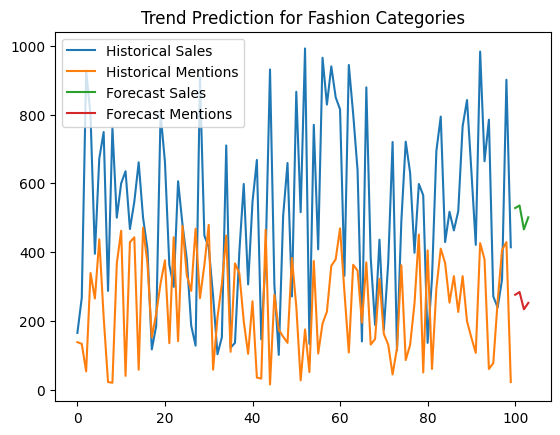

In [ ]:
# Plot trend forecast
future_steps = 4
last_sequence = sales_data[['sales_volume', 'social_mentions']].values[-3:]
forecast = []
for _ in range(future_steps):
    pred = model_lstm.predict(last_sequence[np.newaxis, ...])
    forecast.append(pred[0])
    last_sequence = np.vstack([last_sequence[1:], pred])

plt.plot(scaler.inverse_transform(sales_data[['sales_volume', 'social_mentions']]))
plt.plot(np.arange(len(sales_data), len(sales_data)+4),
         scaler.inverse_transform(forecast))
plt.legend(['Historical Sales', 'Historical Mentions', 'Forecast Sales', 'Forecast Mentions'])
plt.title("Trend Prediction for Fashion Categories")

# **Generating Personalized Recommendations**
A function `recommend_for_user()` generates top-N recommendations for a given user.

### How It Works:
1. **Get All Item IDs**:
   - Creates an array of all possible item indices.
2. **Repeat User ID**:
   - Creates an array with the same user ID repeated for each item.
3. **Predict Scores**:
   - Uses `model_lightfm.predict()` to generate a score for each item.
4. **Select Top-N Items**:
   - Returns the top `num_items` recommendations based on the highest scores.

In [ ]:
# Generate personalized recommendations
def recommend_for_user(user_id, num_items=5):
    # Create array of all possible item indices
    all_items = np.arange(len(item_ids))

    # Create arrays of the same user_id repeated for each item
    user_ids = np.full_like(all_items, user_id)

    # Get predictions for all items for this user
    scores = model_lightfm.predict(
        user_ids=user_ids,
        item_ids=all_items,
        item_features=item_feature_matrix
    )

    # Get top N items
    top_items = np.argsort(-scores)[:num_items]

    # Map indices back to original item IDs
    recommended_item_ids = [item_ids[idx] for idx in top_items]

    # Get the actual images
    return [train_images[item_id] for item_id in recommended_item_ids]

# **Deploying the Recommendation System with Gradio**
A simple web-based interface is created using `Gradio` to allow users to input their ID and receive personalized recommendations.

### Features:
- **User ID Validation**:
  - Checks if the provided user ID exists in the training data.
- **Visualization of Recommendations**:
  - Displays images of the top 5 recommended items using Matplotlib subplots.
- **Interactive Web App**:
  - Users can enter their ID and receive real-time recommendations.

In [ ]:
# ## 5. Deployment Demo
# **Improvement**: Show real-world applicability with Gradio.

def recommend_and_show(user_id: int):
    try:
        # Validate user_id
        if user_id not in user_interactions['user_id'].unique():
            raise ValueError(f"User ID {user_id} not found in training data")

        recommendations = recommend_for_user(int(user_id))

        # Create a figure with subplots for each recommendation
        fig, axes = plt.subplots(1, 5, figsize=(15, 3))
        images = []

        for idx, (img, ax) in enumerate(zip(recommendations, axes)):
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            ax.set_title(f'Item {idx+1}')

        plt.tight_layout()
        return fig
    except Exception as e:
        raise gr.Error(str(e))

# Update the Gradio interface
interface = gr.Interface(
    fn=recommend_and_show,
    inputs=gr.Number(label="User ID", minimum=0, step=1),
    outputs=gr.Plot(),
    title="Personalized Fashion Recommendations",
    description="Enter a user ID to see personalized fashion recommendations"
)

if __name__ == "__main__":
    interface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8066dc153277eb952d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
